In [221]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import collections
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.externals import joblib

%matplotlib inline

# Sources: 
* Used most of the code from: 
https://github.com/bertcarremans/TwitterUSAirlineSentiment/blob/master/source/Predicting%20sentiment%20with%20text%20features.ipynb
* https://towardsdatascience.com/sentiment-analysis-of-tweets-using-multinomial-naive-bayes-1009ed24276b

In [222]:
df = pd.read_csv("user-review.csv")
# Since we have already preprocessed our reviews we can just map and use eval
df['processed_string'] = df['processed'].map(lambda x: eval(x))
df['processed_string'] =  [' '.join(text) for text in df['processed_string']]

# Label the dataset by the scores to assume sentiment
* Data set has already been preprocessed
* less than 3 is low score so negative sentiment
* equal to 3 is neutral sentiment
* greater than 3 is high scoe so positive sentiment
* Users don't download apps that are less than 3 stars

In [223]:
df['sentiment'] = ""
df['sentiment'] = df.apply(
    lambda row: "negative" if (row['score'] < 3) else row['sentiment'],
    axis=1
)

df['sentiment'] = df.apply(
    lambda row: "positive" if (row['score'] > 3) else row['sentiment'],
    axis=1
)

df['sentiment'] = df.apply(
    lambda row: "neutral" if (row['score'] == 3) else row['sentiment'],
    axis=1
)

In [224]:
df.head()

,appTitle,date,score,text,userName,datetime,year,review_length,processed,processed_string,sentiment
0,Google Duo - High Quality Video Calls,"February 4, 2019",5,always the best from Google,enrique Vival,2019-02-04,2019,27,"['best', 'googl']",best googl,positive
1,Messenger – Text and Video Chat for Free,"March 2, 2019",5,good nice and i love it,Maria Borja,2019-03-02,2019,23,"['good', 'nice', 'love']",good nice love,positive
2,Netflix,"January 6, 2016",5,Woo Netflix is now available in Indonesia Wooooo,A Google User,2016-01-06,2016,48,"['netflix', 'avail', 'indonesia', 'wooooo']",netflix avail indonesia wooooo,positive
3,Messenger – Text and Video Chat for Free,"March 18, 2019",5,Ayush sinha Its not too good. Because of this...,A Google User,2019-03-18,2019,155,"['ayush', 'sinha', 'good', 'problem', 'mobil',...",ayush sinha good problem mobil hang overal happi,positive
4,Hangouts,"March 17, 2019",5,its good and nice app,NaN,2019-03-17,2019,21,"['good', 'nice']",good nice,positive


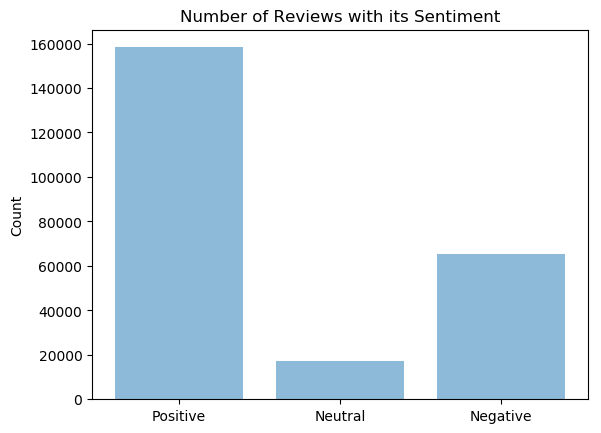

In [5]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
positive = df[df['score'] > 3]
neutral = df[df['score'] == 3]
negative = df[df['score'] < 3]
scores = ('Positive','Neutral', 'Negative')
y_pos = np.arange(len(scores))
numscores = [len(positive), len(neutral),len(negative)]
 
plt.bar(scores, numscores, align='center', alpha=0.5)
plt.xticks(y_pos, scores)
plt.ylabel('Count')
plt.title('Number of Reviews with its Sentiment')
plt.show()

In [6]:
cv = CountVectorizer()
pos = df[df['score'] > 3]['processed_string']
bow_pos = cv.fit_transform(pos)

# Most common words seen in Postive Reviews

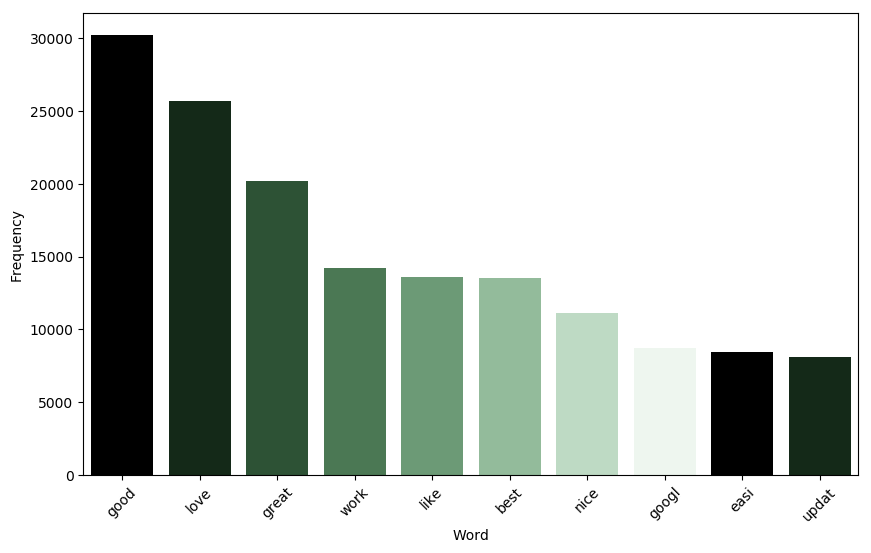

In [7]:
freq_positive = dict(zip(cv.get_feature_names(), np.asarray(bow_pos.sum(axis=0)).ravel()))
count_positive = pd.DataFrame(collections.Counter(freq_positive).most_common(10), columns = ['Word', 'Frequency'])
fig, ax = plt.subplots(figsize=(10, 6))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="Word", y="Frequency", data=count_positive, palette=colour, ax=ax)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.show();

# Most common words seen in Negative Reviews

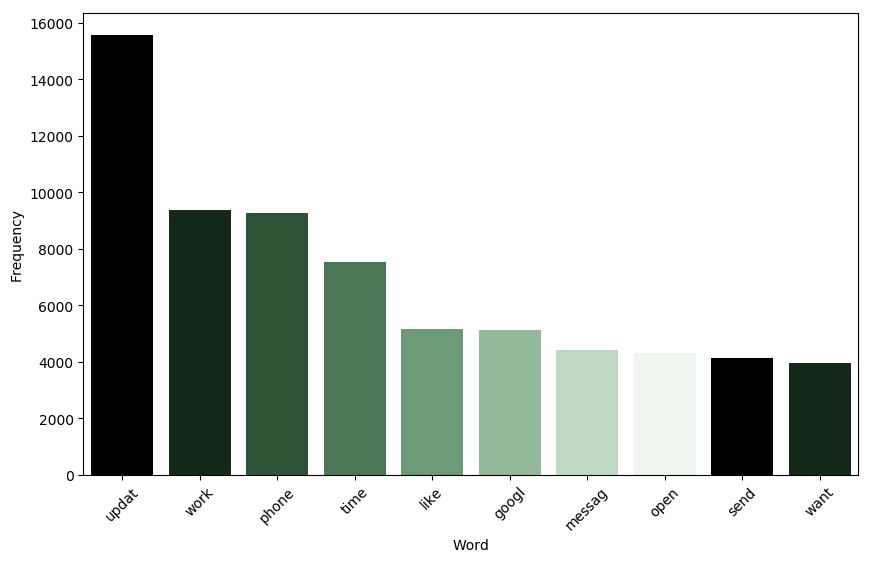

In [8]:
neg = df[df['score'] < 3]['processed_string']
bow_neg = cv.fit_transform(neg)
freq_negative = dict(zip(cv.get_feature_names(), np.asarray(bow_neg.sum(axis=0)).ravel()))
count_negative = pd.DataFrame(collections.Counter(freq_negative).most_common(10), columns = ['Word', 'Frequency'])
fig, ax = plt.subplots(figsize=(10, 6))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="Word", y="Frequency", data=count_negative, palette=colour, ax=ax)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.show();

# Most common words seen in Neutral Reviews

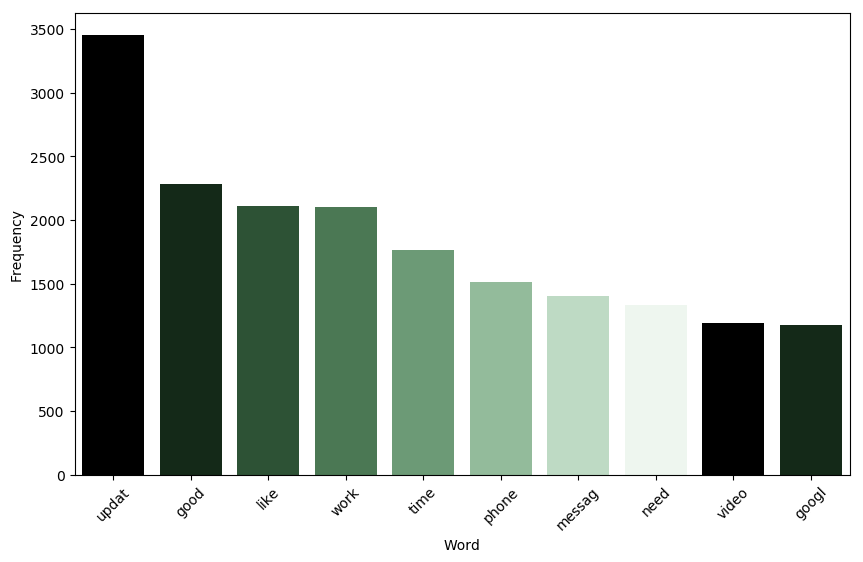

In [9]:
neu = df[df['score'] == 3]['processed_string']
bow_neu = cv.fit_transform(neu)
freq_neutral = dict(zip(cv.get_feature_names(), np.asarray(bow_neu.sum(axis=0)).ravel()))
count_neutral = pd.DataFrame(collections.Counter(freq_neutral).most_common(10), columns = ['Word', 'Frequency'])
fig, ax = plt.subplots(figsize=(10, 6))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="Word", y="Frequency", data=count_neutral, palette=colour, ax=ax)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.show();

# The most frequent words seem to makes sense 

# Remove some of the positive user-reviews so our sentiment for each group is more even, lets take only 65250 positive reviews and 65250 negative reviews 
# We will create our training and test set on this subset of data

In [10]:
len(df[df['score']>3])

158330

In [11]:
index_to_balance = []
for i in range(0,len(df)):
    if df['score'][i] >3:
        index_to_balance.append(i)

In [12]:
158330-len(df[df['score']<3])

93080

In [13]:
import random
index_to_balance = random.sample(index_to_balance, 93080)

# df will be our full data set and lets use a subset that has not dropped the extra positive reviews and call it sub

In [14]:
sub = df
sub = sub.drop(sub.index[index_to_balance])

In [15]:
#check to make sure that the difference matches 
len(df)-len(sub)

93080

In [16]:
len(df[df['score']<3])

65250

# I'm not necessarily sure if the number of neutral reviews will make big difference for the classifiers but lets try it out (Since I only balanced the positive and negative reviews to be 65250 each sentiment)

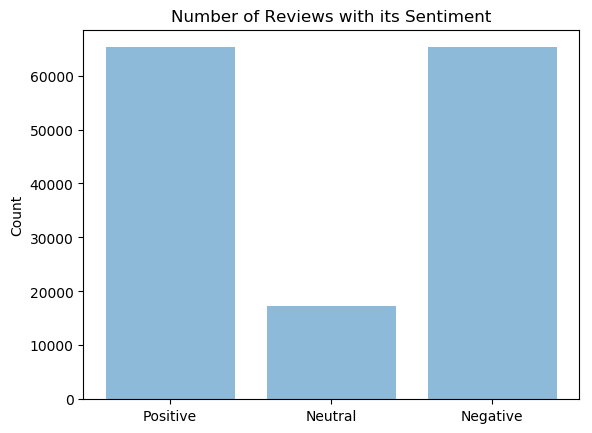

In [17]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
positive = sub[sub['score'] > 3]
neutral = sub[sub['score'] == 3]
negative = sub[sub['score'] < 3]
scores = ('Positive','Neutral', 'Negative')
y_pos = np.arange(len(scores))
numscores = [len(positive), len(neutral),len(negative)]
 
plt.bar(scores, numscores, align='center', alpha=0.5)
plt.xticks(y_pos, scores)
plt.ylabel('Count')
plt.title('Number of Reviews with its Sentiment')
plt.show()

In [18]:
text_train, text_test, sentiment_train, sentiment_test = train_test_split(sub,
                                                    sub['sentiment'],
                                                    test_size=0.15, 
                                                    random_state=509)

# ` CountVectorizer()` , We can expect a sparse matrix since there are many zero's from the many reviews 

# Use GridsearchCV to optimize tuning parameters 

In [19]:
# https://github.com/bertcarremans/TwitterUSAirlineSentiment/blob/master/source/Predicting%20sentiment%20with%20text%20features.ipynb
param_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# multinomial naive bayes parameters
param_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}
# logistic regression parameters
param_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [20]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols
    def transform(self, X, **transform_params):
        return X[self.cols]
    def fit(self, X, y=None, **fit_params):
        return self

In [21]:
def grid_vect(clf, parameters_clf, text_train, text_test, parameters_text=None, vect=None):
    features = FeatureUnion([('pipe', Pipeline([('processedtext', ColumnExtractor(cols='processed_string')), ('vect', vect)]))]
                                , n_jobs=-1)
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)])
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    t0 = time()
    grid_search.fit(text_train, sentiment_train)
    print("done in %0.3fs" % (time() - t0))
    print("\n")
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name])) 
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(text_test, sentiment_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(sentiment_test, grid_search.best_estimator_.predict(text_test)))
                        
    return grid_search

# Using Multinomial Naive Bayes
* An advantage of naive Bayes is that it only requires a small number of training data to estimate the parameters necessary for classification

# Multinomial Naive Bayes (CountVectorizer)

In [91]:
mnb = MultinomialNB()
logreg = LogisticRegression()
countvect = CountVectorizer()
mnb_countvect = grid_vect(mnb, param_mnb, text_train, text_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.8min finished


done in 423.457s

Best CV score: 0.756
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.757


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.71      0.90      0.79      6501
     neutral       0.36      0.03      0.06      1777
    positive       0.82      0.81      0.82      6502

   micro avg       0.76      0.76      0.76     14780
   macro avg       0.63      0.58      0.56     14780
weighted avg       0.72      0.76      0.72     14780



# Logistic Regression (CountVectorizer)

In [93]:
logreg_countvect = grid_vect(logreg, param_logreg, text_train, text_test, parameters_text=parameters_vect, vect=countvect)

{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 27.0min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


done in 1648.896s

Best CV score: 0.763
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.766


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.75      0.87      0.80      6501
     neutral       0.39      0.05      0.09      1777
    positive       0.80      0.86      0.83      6502

   micro avg       0.77      0.77      0.77     14780
   macro avg       0.65      0.59      0.57     14780
weighted avg       0.73      0.77      0.73     14780



# Multinomial Naive Bayes (TFIDF)
* use TFIDF to downweight frequent words

In [94]:
tfidf = TfidfVectorizer()
mnb_tfidf = grid_vect(mnb, param_mnb, text_train, text_test, parameters_text=parameters_vect, vect=tfidf)


{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.9min finished


done in 429.241s

Best CV score: 0.756
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.755


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.70      0.92      0.79      6501
     neutral       0.00      0.00      0.00      1777
    positive       0.84      0.80      0.82      6502

   micro avg       0.76      0.76      0.76     14780
   macro avg       0.51      0.57      0.54     14780
weighted avg       0.67      0.76      0.71     14780



/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Logistic Regression (TFIDF)

In [44]:
tfidf = TfidfVectorizer()
logreg = LogisticRegression()
logreg_tfidf = grid_vect(logreg, param_logreg, text_train, text_test, parameters_text=parameters_vect, vect=tfidf)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 13.8min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


done in 840.613s


Best CV score: 0.765
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.769


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.74      0.89      0.81      9900
     neutral       0.34      0.03      0.05      2546
    positive       0.82      0.84      0.83      9724

   micro avg       0.77      0.77      0.77     22170
   macro avg       0.63      0.59      0.56     22170
weighted avg       0.73      0.77      0.73     22170



In [50]:
newsub = sub.sample(n=50000, random_state=1)

In [51]:
text_train, text_test, sentiment_train, sentiment_test = train_test_split(newsub,
                                                    newsub['sentiment'],
                                                    test_size=0.15, 
                                                    random_state=509)

In [56]:
len(newsub[newsub['score'] > 3])

22205

In [57]:
len(newsub[newsub['score'] < 3])

21998

In [58]:
len(newsub[newsub['score'] == 3])

5797

# The GNB and LinearSVC runs on too much ram will cause kernel to die so we create newsub which is of only 50000 records


* Gaussian Naive Bayes (Countvectorizer)
* Since there is no hyper parameter to tune for Gaussian Naive Bayes we wont use gridsearchCV

In [79]:
gnb = GaussianNB()
countvect = CountVectorizer()

train = countvect.fit_transform(text_train['processed_string'])
gnb.fit(train.toarray(), sentiment_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [80]:
test = countvect.transform(text_test['processed_string'])
pred = gnb.predict(test.toarray())

In [81]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(sentiment_test, pred))
print("Precision, Recall, F1 score:",metrics.precision_recall_fscore_support(sentiment_test, pred))

Accuracy: 0.2152
Precision, Recall, F1 score: (array([0.63900415, 0.11771562, 0.5771725 ]), array([0.14076782, 0.80707763, 0.1331538 ]), array([0.23071161, 0.20546353, 0.21638707]), array([3282,  876, 3342]))


# Lets try LinearSVC

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

countvect = CountVectorizer()
linearsvc = LinearSVC()

train = countvect.fit_transform(text_train['processed_string'])  
test = countvect.transform(text_test['processed_string'])
linearsvc.fit(train.toarray(), sentiment_train)
pred_svc = linearsvc.predict(test.toarray())
print("Accuracy:",metrics.accuracy_score(sentiment_test, pred_svc))

/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.7361333333333333


In [85]:
print("Precision, Recall, F1 score:", metrics.precision_recall_fscore_support(sentiment_test, pred_svc))

Precision, Recall, F1 score: (array([0.72464941, 0.28225806, 0.77990971]), array([0.8187081 , 0.07990868, 0.82704967]), array([0.76881259, 0.12455516, 0.80278827]), array([3282,  876, 3342]))


# Gaussian Naive Bayes is pretty bad, but LinearSVC seems to be ok

# But we have trouble predicting neutral sentiment for all the methods
# we also conlcude that we get best results of 0.769 with logistic regression(TFIDF)

# Lets use the best model and predict our sentiment for the entire data set 

In [114]:
vect = TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1,2))
features = FeatureUnion([('pipe', Pipeline([('processedtext', ColumnExtractor(cols='processed_string')), ('vect', vect)]))]
                                , n_jobs=-1)
pipeline = Pipeline([('features', features), ('clf', LogisticRegression(C=1.0, penalty='l2'))])
    
best_model = pipeline.fit(text_train,sentiment_train)

In [118]:
predict = best_model.predict(df)

In [122]:
print("Accuracy:",metrics.accuracy_score(df['sentiment'], predict))

Accuracy: 0.7986457650057707


In [123]:
print("Precision, Recall, F1 score:", metrics.precision_recall_fscore_support(df['sentiment'], predict))

Precision, Recall, F1 score: (array([0.62211   , 0.37227414, 0.91531676]), array([0.89115709, 0.02763964, 0.84473568]), array([0.73271631, 0.05145871, 0.87861101]), array([ 65250,  17294, 158330]))


# The metrics seem ok if we assumed the sentiment based on the scores are correct, We could try to use this classifier as a preprocessing tool to filter out non-informative text but the accuracy is still worth looking in to. It may not be as great as the SentiStrength classifier. 

In [225]:
df['new_sentiment'] = predict

# We now have a sentiment based on scores and a new_sentiment from our classifier

In [228]:
df.head()

,appTitle,date,score,text,userName,datetime,year,review_length,processed,processed_string,sentiment,new_sentiment
0,Google Duo - High Quality Video Calls,"February 4, 2019",5,always the best from Google,enrique Vival,2019-02-04,2019,27,"['best', 'googl']",best googl,positive,positive
1,Messenger – Text and Video Chat for Free,"March 2, 2019",5,good nice and i love it,Maria Borja,2019-03-02,2019,23,"['good', 'nice', 'love']",good nice love,positive,positive
2,Netflix,"January 6, 2016",5,Woo Netflix is now available in Indonesia Wooooo,A Google User,2016-01-06,2016,48,"['netflix', 'avail', 'indonesia', 'wooooo']",netflix avail indonesia wooooo,positive,positive
3,Messenger – Text and Video Chat for Free,"March 18, 2019",5,Ayush sinha Its not too good. Because of this...,A Google User,2019-03-18,2019,155,"['ayush', 'sinha', 'good', 'problem', 'mobil',...",ayush sinha good problem mobil hang overal happi,positive,positive
4,Hangouts,"March 17, 2019",5,its good and nice app,NaN,2019-03-17,2019,21,"['good', 'nice']",good nice,positive,positive


In [231]:
len(df)

240874

# Lets remove the records that don't have matching sentiment

In [239]:
count = 0
notmatch = []
for i in range(0, len(df)):
    if df['sentiment'][i] != df['new_sentiment'][i]:
        count +=1
        notmatch.append(count)
        
        

In [245]:
print('we will need to remove ' +str(len(notmatch))+' number of records that are not matching')

we will need to remove 48501 number of records that are not matching


In [254]:
newdf = df.drop(df.index[notmatch])
newdf = newdf.drop('new_sentiment', axis = 1)
newdf.to_csv("without-noninformative.csv",index= False)


In [256]:
len(df)

240874

In [257]:
len(newdf)

192373

# Now we can use this new data set to run topic modelling again to see if we achieve any better results 

# Extra Analysis
* lets look at the sentiment of each app

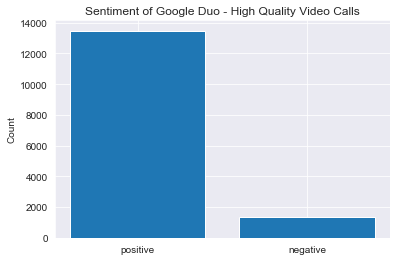

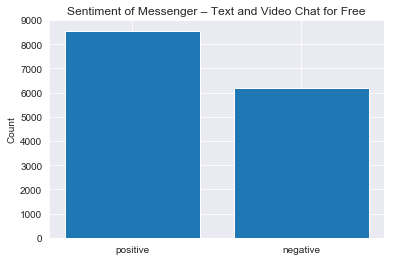

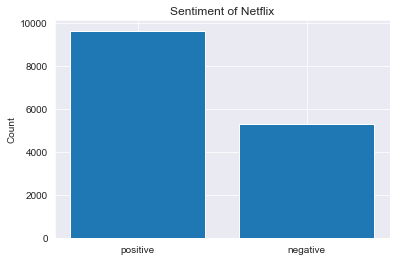

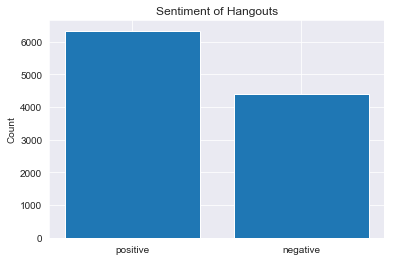

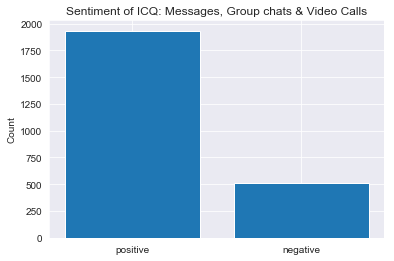

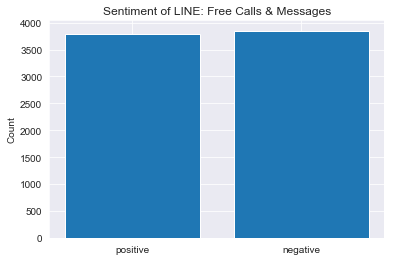

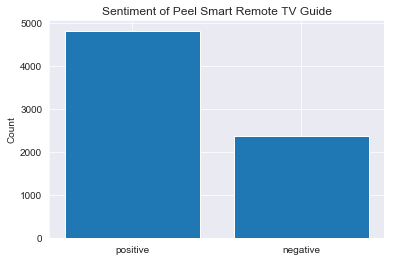

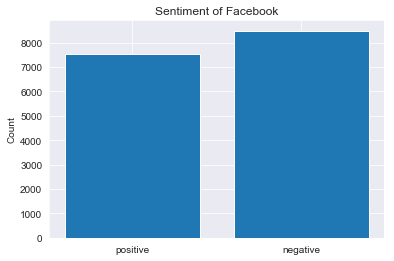

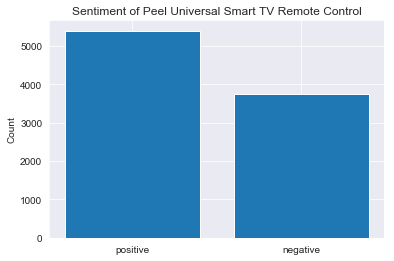

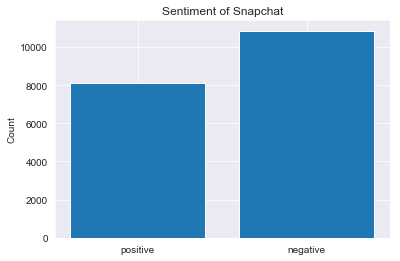

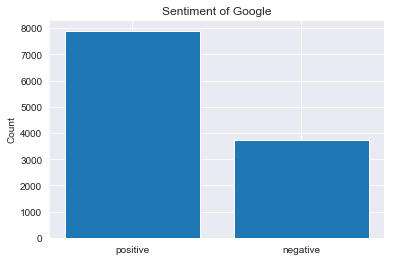

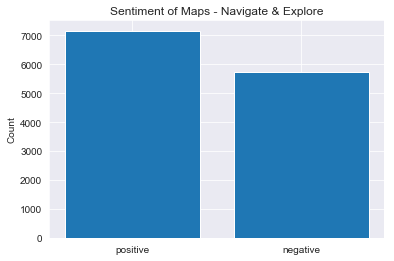

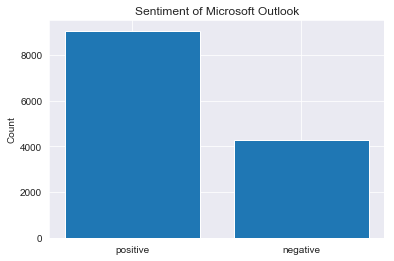

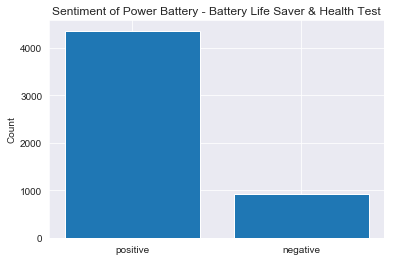

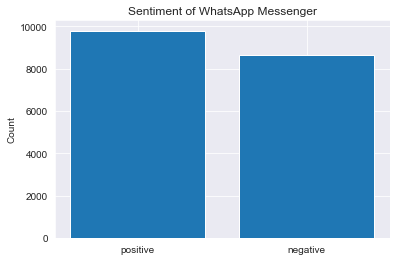

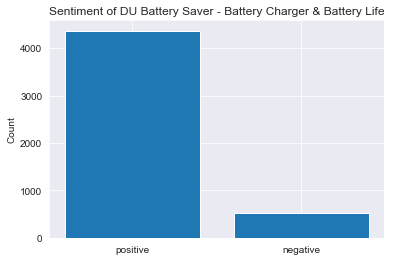

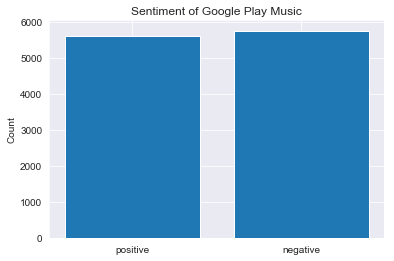

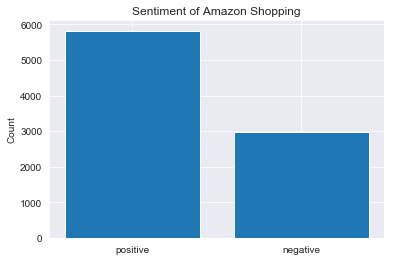

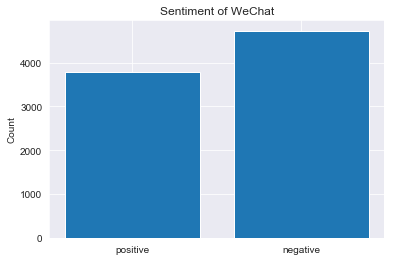

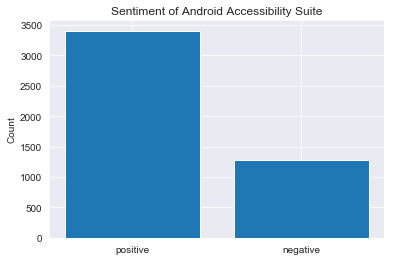

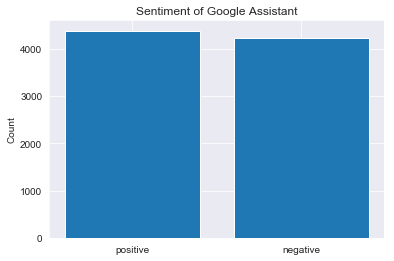

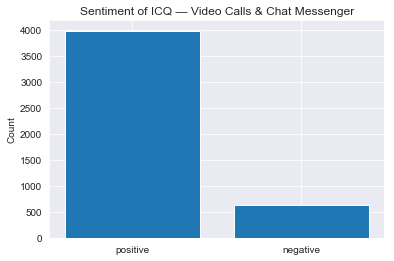

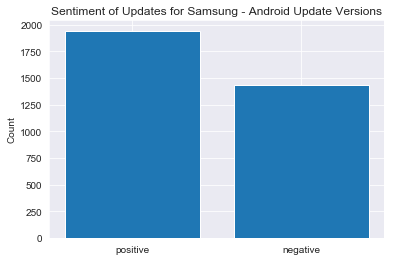

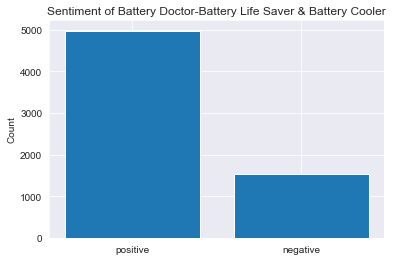

In [230]:
for i in df['appTitle'].unique():
    apps = df[df['appTitle']==i]
    snap_list = [len(apps[apps['new_sentiment'] == 'positive']),len(apps[apps['new_sentiment'] == 'negative'])]
    plt.bar( ['positive','negative'],snap_list)
    plt.ylabel('Count')
    plt.title('Sentiment of '+str(i))
    plt.show()


# We can see that 
* People are most concerned about: Facebook, Wechat, Line, Snapchat, Google Play Music
* This is quite interesting to see since most of the battery apps don't seem to be a big concern overall, but in the topic modelling done before there exist quite a few topics complaining about ads and usability of those battery apps

# Re-running one part of Topic modelling for 2019 to see if removing the non-informative reviews made a difference

In [261]:
import gensim
import gensim.corpora as corpora

In [258]:
year1 = newdf[newdf['year']==2019]
len(year1)

123432

In [259]:
high = year1[year1['score']>3]
low = year1[year1['score']<3]

low =low.reset_index(drop=True)
high = high.reset_index(drop=True)

In [262]:
bigram_high = gensim.models.phrases.Phraser(gensim.models.Phrases(high['processed'].tolist(),
                                                                     min_count=5,
                                                                     threshold=100))
#min_count = 5 => appearing at least 5 times 
trigram_high = gensim.models.phrases.Phraser(gensim.models.Phrases(bigram_high[high['processed'].tolist()],
                                                                      threshold=100))
bigram_low = gensim.models.phrases.Phraser(gensim.models.Phrases(low['processed'],
                                                                    min_count=5, 
                                                                    threshold=100))

trigram_low = gensim.models.phrases.Phraser(gensim.models.Phrases(gensim.models.Phrases(bigram_low[low['processed'].tolist()],
                                                                      threshold=100)[low['processed']],
                                                                     threshold=100))

bigrams_high = [bigram_high[sentence] for sentence in high['processed'].tolist()]
trigrams_high = [trigram_high[bigram_high[sentence]] for sentence in high['processed'].tolist()]

bigrams_low = [bigram_low[sentence] for sentence in low['processed'].tolist()]
trigrams_low = [trigram_low[bigram_low[sentence]] for sentence in low['processed'].tolist()]



In [265]:
import gensim
import gensim.corpora as corpora

dic1 = corpora.Dictionary(trigrams_low)
# keep only the terms that appear more than 3 times and only the top 10000
dic1.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 10000)
document1 =trigrams_low

# Should we only keep the top 10000 when the length of the dictionary is 18000?
# id2word1.filter_extremes(keep_n = 10000)

corpus_low = [dic1.doc2bow(text) for text in document1]

dic2 = corpora.Dictionary(trigrams_high)
dic2.filter_extremes(no_above = 3, no_below = 0.1, keep_n = 20000)
document2 =trigrams_high

corpus_high = [dic2.doc2bow(text) for text in document2]

In [267]:
import os
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
low_coherence = []
high_coherence = []

# since we want to know the coherence of different topics lets write a loop to iterate to the multiple topics 
topics  = [5,10,15,20,25,30]
for i in topics:
    mallet_low = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_low, 
                                              num_topics=i,
                                              id2word=dic1,
                                              workers = 4,random_seed = 2013)
    coherence_mallet_low = CoherenceModel(model=mallet_low, texts=document1, dictionary=dic1, coherence='c_v').get_coherence()
    low_coherence.append(coherence_mallet_low)
    
    mallet_high = gensim.models.wrappers.LdaMallet('/Users/chi/desktop/twitterproject/mallet-2.0.8/bin/mallet', 
                                              corpus=corpus_high, 
                                              num_topics=i,
                                              id2word=dic2, 
                                              workers = 4, random_seed = 2013)
    coherence_mallet_high = CoherenceModel(model=mallet_high, texts=document2, dictionary=dic2, coherence='c_v').get_coherence()
    high_coherence.append(coherence_mallet_high)

In [268]:
low_coherence 


[0.2874321019392883,
 0.2880264756101162,
 0.28762855767934015,
 0.2879485826984617,
 0.287953718374894,
 0.2880793543178709]

In [269]:
high_coherence 

[0.27000104574341244,
 0.2695744246255657,
 0.2705404957556104,
 0.2698611622178418,
 0.2700585890585215,
 0.2706753582586599]

# Coherence scores actually dropped by quite a lot so maybe this classifier isn't doing a great job